In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
class Config:
    vocab_size = 15000 # Vocabulary Size
    tfidf_vocab_size = 20000
    sequence_length = 100 # Length of sequence
    batch_size = 1024
    validation_split = 0.15
    embed_dim = 256
    latent_dim = 256
    epochs = 10 # Number of Epochs to train
    best_auc_model_path = "model_best_auc.weights.h5"  
    best_acc_model_path = "model_best_acc.weights.h5"  
    lastest_model_path = "model_latest.weights.h5"  
    output_dataset_path = "../input/toxicity-classification-word2vectfidf-output"
    labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    modes = ["training", "inference"]
    mode = modes[0]
config = Config()

In [2]:
import pandas as pd
import tensorflow as tf
import pathlib
import random
import string
import re
import sys
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import os
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer 
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.stats import rankdata
import json

In [3]:
train_path = os.path.join('F:','jigsaw-toxic-comment-classification-challenge', 'train.csv.zip')

In [4]:
train = pd.read_csv(train_path)

In [5]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
@tf.keras.utils.register_keras_serializable()
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    text = tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )
    text = tf.strings.regex_replace(text, f"[0-9]+", " ")
    text = tf.strings.regex_replace(text, f"[ ]+", " ")
    text = tf.strings.strip(text)
    return text

In [7]:
from tensorflow.keras.layers import TextVectorization

# Khởi tạo lớp TextVectorization với hàm custom_standardization
tfidf_vectorizer = TextVectorization(
    standardize=custom_standardization, 
    max_tokens=config.tfidf_vocab_size, 
    output_mode="tf-idf", 
    ngrams=2
)

with tf.device("CPU"):
    tfidf_vectorizer.adapt(list(train["comment_text"]))

In [8]:
X_train, X_val, y_train, y_val = train_test_split(train["comment_text"], train[config.labels], test_size=config.validation_split)

In [9]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((135635,), (135635, 6), (23936,), (23936, 6))

In [10]:
def make_dataset(X, y, batch_size, mode):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if mode == "train":
       dataset = dataset.shuffle(256) 
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache().prefetch(16).repeat(1)
    return dataset

In [11]:
train_ds = make_dataset(X_train, y_train, batch_size=config.batch_size, mode="train")
valid_ds = make_dataset(X_val, y_val, batch_size=config.batch_size, mode="valid")

In [12]:
for batch in train_ds.take(1):
    print(batch)

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
array([b'My commets \n\nSomebody erased my comments on you discussion page see in history: Jan Dzierzon and Name.\nAndrew',
       b"Removing Warnings\nPlease do not remove messages from your talk page. Talk pages exist as a record of communication, and in any case, comments are available through the page history. You're welcome to archive your talk page, but be sure to provide a link to any deleted comments. Thanks.",
       b'"""In recent years, the word Goth has often been used to describe a wider social group of youths. These might include people with a tendency to wear black clothes, listen to Death Metal or wear goth-style make up. Often, those labelled as Goths lack many of the characteristics historically associated with the subculture, and are sometimes called mallgoths."" The major social group of goths, or ""mallgoths"" are usually linked with nu-metal, not death metal. Explain where this proof of gothic like youths listening 

In [13]:
def get_tfidf_model(config, inputs):
    x = tfidf_vectorizer(inputs)
    x = layers.Dense(256, activation="relu", kernel_regularizer="l2")(x)
    x = layers.Dense(100, activation="relu", kernel_regularizer="l2")(x)
    return x

In [14]:
def get_model(config):
    inputs = keras.Input(shape=(1, ), dtype="string", name="inputs")
    tfidf_x = get_tfidf_model(config, inputs)   
    output = layers.Dense(6, activation="sigmoid")(tfidf_x)
    model = keras.Model(inputs, output, name="model")
    return model

In [15]:
model = get_model(config)

In [16]:
model.compile(
    "adam", loss="binary_crossentropy", metrics=["categorical_accuracy", keras.metrics.AUC()]
)

In [21]:
if config.mode == config.modes[0]:
    acc_checkpoint = keras.callbacks.ModelCheckpoint(config.best_acc_model_path, monitor="val_categorical_accuracy",save_weights_only=True, save_best_only=True)
    auc_checkpoint = keras.callbacks.ModelCheckpoint(config.best_auc_model_path, monitor="val_auc",save_weights_only=True, save_best_only=True)
    early_stopping = keras.callbacks.EarlyStopping(patience=10)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=5, min_delta=1e-4, min_lr=1e-6)
    model.fit(train_ds, epochs=config.epochs, validation_data=valid_ds, callbacks=[acc_checkpoint, auc_checkpoint, reduce_lr])
    model.save_weights(config.lastest_model_path)

Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 42s 308ms/step - auc: 0.9155 - categorical_accuracy: 0.9112 - loss: 0.1707 - val_auc: 0.9570 - val_categorical_accuracy: 0.9939 - val_loss: 0.1272 - learning_rate: 0.0010
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 40s 304ms/step - auc: 0.9577 - categorical_accuracy: 0.9894 - loss: 0.1268 - val_auc: 0.9582 - val_categorical_accuracy: 0.9939 - val_loss: 0.1231 - learning_rate: 0.0010
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 38s 284ms/step - auc: 0.9585 - categorical_accuracy: 0.9926 - loss: 0.1219 - val_auc: 0.9595 - val_categorical_accuracy: 0.9939 - val_loss: 0.1198 - learning_rate: 0.0010
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 42s 315ms/step - auc: 0.9597 - categorical_accuracy: 0.9938 - loss: 0.1175 - val_auc: 0.9587 - val_categorical_accuracy: 0.9939 - val_loss: 0.1163 - learning_rate: 0.0010
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 42s 313ms/step - auc: 0.9610 - categorical_accuracy: 0.9937 - loss: 0.1136 - val_auc: 0.9594 - val_categorical_accur

In [22]:
if config.mode == config.modes[0]:
    from sklearn.metrics import classification_report
    y_pred = np.array(model.predict(valid_ds) > 0.5, dtype=int)
    cls_report = classification_report(y_val, y_pred)
    print(cls_report)

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step
              precision    recall  f1-score   support

           0       0.93      0.46      0.62      2316
           1       0.62      0.07      0.12       226
           2       0.85      0.55      0.67      1255
           3       0.00      0.00      0.00        64
           4       0.80      0.51      0.63      1185
           5       1.00      0.00      0.01       218

   micro avg       0.87      0.45      0.60      5264
   macro avg       0.70      0.27      0.34      5264
weighted avg       0.86      0.45      0.58      5264
 samples avg       0.04      0.04      0.04      5264



F:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
model.load_weights("C:\\Users\\ADMIN\\model_best_acc.weights.h5", skip_mismatch=False)

F:\Anaconda\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [48]:
import assemblyai as aai
import tensorflow as tf

Test văn bản

In [57]:
aai.settings.api_key = "6d5a104708cc4a5a96b4538cd8bccd5e"
config = aai.TranscriptionConfig(language_detection=True)
transcriber = aai.Transcriber(config=config)
transcript = transcriber.transcribe("F:\\all mp3\\nontoxic4.mp3")
audio_text = transcript.text
sentences = []
start_idx = 0
batch_size=32
for idx, char in enumerate(audio_text):
    if char in [".", "!", "?"] and idx < len(audio_text) - 1:
        sentence = audio_text[start_idx:idx + 1].strip().replace(",", "")
        sentences.append(sentence)
        start_idx = idx + 1

# In ra danh sách các câu
for sentence in sentences:
    print(sentence)
    

This is my house.
It's not big and it's not small but I like it.
Three people live here.
This is Matt.
Hi I'm Matt.
This is David.
Hello.
My name's David.
And that's me.
Hi.
Helen.
Pleased to meet you.
So there are three people but there are four bedrooms.
So today is interview day.
But he's very quiet and friendly.
No dogs.
Sorry.
150 pounds a month.
Great.
Uh no 150 pounds a week.
Sorry.
Where are you from?
Edinburgh but my job's in Oxford.
Good.
This is a nice house.
Thanks.
We're happy here.
Okay.
Okay.
Anti cabaret.
I don't smoke.
We don't smoke do we?
Uh no we don't smoke.
Oh sorry.
This is terrible.
Who's next?
Her name's Jane.
She's number eight.
She's the last.
So Jane tell us about yourself.
Tell you what?
Anything.
I'm from Brighton.
I'm a drama teacher.
I don't smoke.
I like films good food.
Good food yeah.
Italian?
French?
Chinese.
Do you cook?
Yes I'm a very good cook.
Do you have a dog?
No.
Cat?
No.
No animals.
Do you play the drums?
No.
The trombone?
Violin?
Saxophone?


In [58]:
import pandas as pd

# Tạo DataFrame từ danh sách audio_text và chỉ mục tương ứng
df = pd.DataFrame({"audio_text": sentences})

# In ra một số dòng đầu tiên của DataFrame để kiểm tra
print(df.head())


                                       audio_text
0                               This is my house.
1  It's not big and it's not small but I like it.
2                         Three people live here.
3                                   This is Matt.
4                                    Hi I'm Matt.


In [59]:
unique_words = set(audio_text.split())
unique_word_count = len(unique_words)
print( unique_word_count)

850


In [60]:
batch_size = 1024
best_acc_model_path = "model_best_acc.weights.h5"
modes = ["training", "inference"]
mode = modes[0]
output_dataset_path = "../input/toxicity-classification-word2vectfidf-output"
scores = []
test_ds = tf.data.Dataset.from_tensor_slices(df.audio_text).batch(batch_size).cache().prefetch(1)
for path in [best_acc_model_path]:
#for path in [config.best_acc_model_path, config.best_auc_model_path, config.lastest_model_path]:
    if mode == modes[1]:
        path = output_dataset_path + "/" + path
    model.load_weights(path)
    score = model.predict(test_ds)
    scores.append(score)
score = np.mean(scores, axis=0)
print(score.shape)
print(score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
(590, 6)
[[0.14909653 0.01468439 0.08523972 0.0078085  0.0787352  0.02079093]
 [0.09979299 0.00737659 0.05159999 0.00368432 0.04763365 0.01141286]
 [0.09779303 0.00757786 0.05164098 0.00380955 0.04773628 0.01166412]
 ...
 [0.12540795 0.01163922 0.07026038 0.00614927 0.0649677  0.01735252]
 [0.0894905  0.00455202 0.0395858  0.00217471 0.03773706 0.00762167]
 [0.08581647 0.00399381 0.03697832 0.00188489 0.03535555 0.00686198]]


F:\Anaconda\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


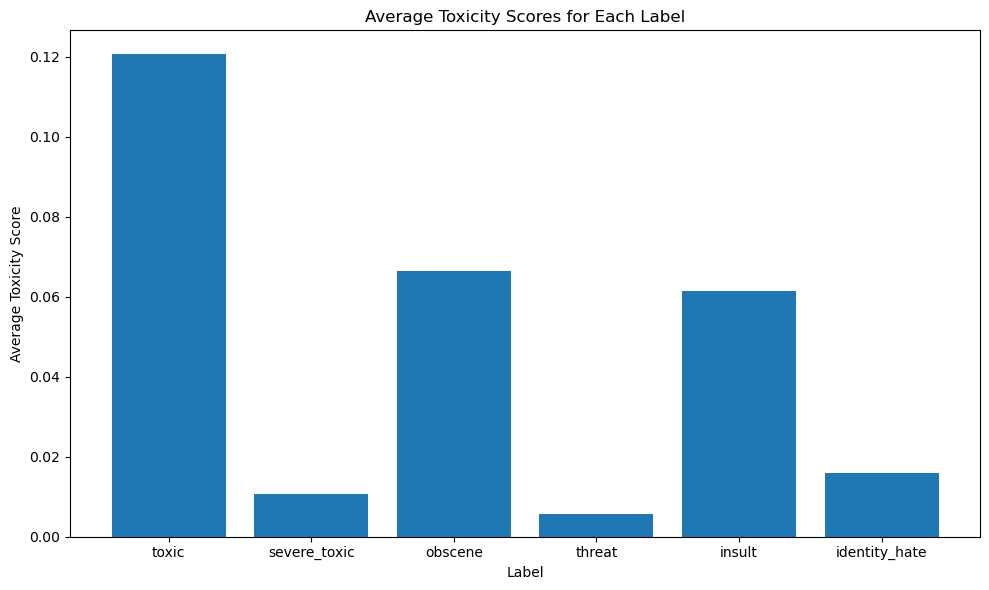

In [61]:
import numpy as np
import matplotlib.pyplot as plt


mean_scores = np.mean(score, axis=0)


labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]


plt.figure(figsize=(10, 6))
plt.bar(labels, mean_scores)


plt.title('Average Toxicity Scores for Each Label')
plt.xlabel('Label')
plt.ylabel('Average Toxicity Score')


plt.tight_layout()
plt.show()


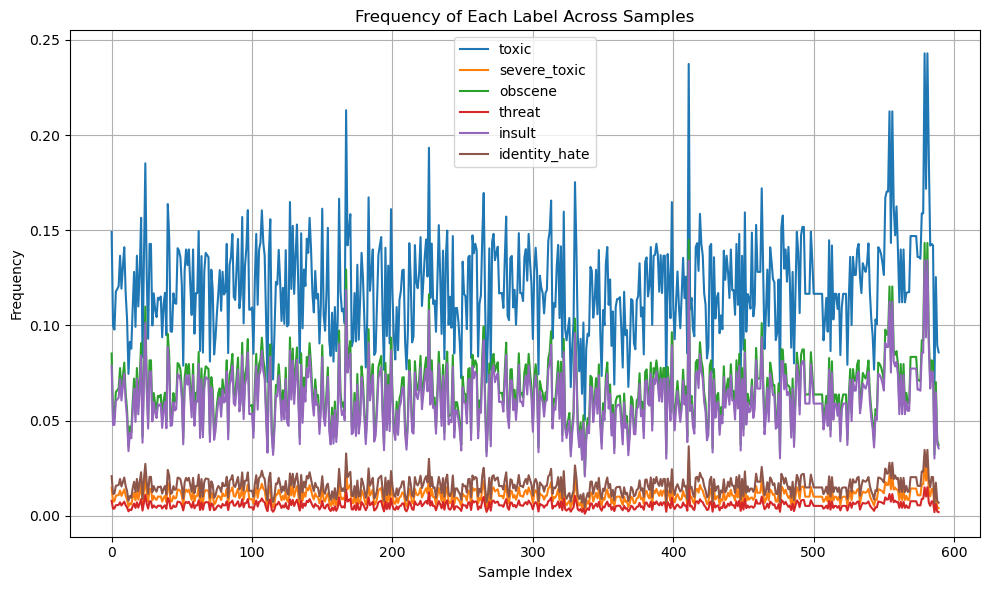

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Tính tần suất của mỗi nhãn qua các mẫu dữ liệu
frequencies = score.mean(axis=0)


labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]


plt.figure(figsize=(10, 6))
for i in range(len(labels)):
    plt.plot(np.arange(len(score)), score[:, i], label=labels[i])


plt.title('Frequency of Each Label Across Samples')
plt.xlabel('Sample Index')
plt.ylabel('Frequency')


plt.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.grid(True)
plt.show()


In [63]:
import numpy as np

# Tính điểm trung bình cho mỗi nhãn
average_scores = np.mean(score, axis=0)
# Kiểm tra nếu điểm trung bình của bất kỳ nhãn nào lớn hơn 0.20
predicted_labels = []
for i, label in enumerate(labels):
    if average_scores[i] > 0.20:
        predicted_labels.append(label)

# Hiển thị kết quả trên một dòng
if predicted_labels:
    print(f"Đoạn âm thanh có nội dung {', '.join(predicted_labels)}.")
else:
    print("Đoạn âm thanh không có nội dung độc hại.")
for percent in average_scores * 100:
    print(f"{percent:.2f}%")

Đoạn âm thanh không có nội dung độc hại.
12.05%
1.07%
6.63%
0.56%
6.15%
1.58%


Két quả trên tệp test.csv

In [103]:
test_path=os.path.join('Downloads', 'jigsaw-toxic-comment-classification-challenge', 'test.csv.zip')
test = pd.read_csv(test_path)
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [104]:
scores = []
test_ds = tf.data.Dataset.from_tensor_slices((test["comment_text"])).batch(config.batch_size).cache().prefetch(1)
for path in [config.best_auc_model_path]:
#for path in [config.best_acc_model_path, config.best_auc_model_path, config.lastest_model_path]:
    if config.mode == config.modes[1]:
        path = config.output_dataset_path + "/" + path
    model.load_weights(path)
    score = model.predict(test_ds)
    scores.append(score)
score = np.mean(scores, axis=0)
print(score.shape)

  1/150 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step

F:\Anaconda\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step
(153164, 6)


In [105]:
ss_path=os.path.join('Downloads', 'jigsaw-toxic-comment-classification-challenge', 'sample_submission.csv.zip')
sample_submission = pd.read_csv(ss_path)
sample_submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [106]:
sample_submission[config.labels] = score
sample_submission.to_csv("submission.csv", index=False)
sample_submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.873187,0.000434,0.427671,0.000014,0.271099,0.000169
1,0000247867823ef7,0.079963,0.041030,0.066374,0.018390,0.057014,0.075613
2,00013b17ad220c46,0.113115,0.033262,0.083339,0.013646,0.071020,0.056414
3,00017563c3f7919a,0.013232,0.002103,0.007891,0.000389,0.005807,0.005709
4,00017695ad8997eb,0.165423,0.080833,0.133359,0.045381,0.118983,0.121734


In [107]:
print(sample_submission[config.labels])

           toxic  severe_toxic   obscene        threat    insult  \
0       0.873187      0.000434  0.427671  1.409985e-05  0.271099   
1       0.079963      0.041030  0.066374  1.838982e-02  0.057014   
2       0.113115      0.033262  0.083339  1.364577e-02  0.071020   
3       0.013232      0.002103  0.007891  3.887181e-04  0.005807   
4       0.165423      0.080833  0.133359  4.538065e-02  0.118983   
...          ...           ...       ...           ...       ...   
153159  0.135295      0.064666  0.108789  3.389492e-02  0.093196   
153160  0.075442      0.000570  0.023902  4.794794e-05  0.016878   
153161  0.018562      0.000034  0.003931  9.987247e-07  0.002438   
153162  0.011146      0.000002  0.001279  1.710910e-08  0.000625   
153163  0.269161      0.026664  0.151647  9.383066e-03  0.124793   

        identity_hate  
0            0.000169  
1            0.075613  
2            0.056414  
3            0.005709  
4            0.121734  
...               ...  
153159       0.